<h1> 코칭스터디 [beyond AI] 1주차 미션 </h1> 

---

## <h2>캐글 코리아 대회 - House Price Prediction </h2>

- [캐글 코리아와 함께하는 2nd ML 대회 - House Price Prediction](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)


### [RMSE 수식]
RMSE = sqrt(mean((예측값 - 실제값)^2))
RMSE(Root Mean Squared Error)가 작을수록 더 정확한 모델

모델 학습용 파일 : `train.csv`
테스트용 파일 : `test.csv`
제출용 파일 : `sample_submission.csv`
=> `train.csv` 활용하여 모델을 학습 -> `test.csv` 데이터에 대해 `price`를 예측 -> `sample_submission.csv`의 형식에 맞추어 제출

<h2><strong> 베이스라인 모델 세팅 </strong></h2>

- [2019 ML month 2nd baseline 커널](https://www.kaggle.com/code/kcs93023/2019-ml-month-2nd-baseline/notebook)



<div class="markdown-google-sans">

## 데이터 전처리

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# 데이터 다운로드 
!wget –no-check-certificate 'https://docs.google.com/uc?export=download&id=1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0' -O kaggle-kakr-housing-data.zip


--2023-05-07 07:14:00--  http://xn--no-check-certificate-2t2l/
Resolving xn--no-check-certificate-2t2l (xn--no-check-certificate-2t2l)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--no-check-certificate-2t2l’
--2023-05-07 07:14:00--  https://docs.google.com/uc?export=download&id=1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0
Resolving docs.google.com (docs.google.com)... 172.253.123.113, 172.253.123.138, 172.253.123.100, ...
Connecting to docs.google.com (docs.google.com)|172.253.123.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b9pbo8mgi7r80fee7g71lg0qcv559v6m/1683443625000/17597719433809694239/*/1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0?e=download&uuid=a8c9f8b0-8795-49dd-943c-67963ec0f4e3 [following]
--2023-05-07 07:14:01--  https://doc-00-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b9pbo8mgi7r80fee7g71lg0qcv

In [2]:
# 다운로드 받은 zip파일 압축풀기
!unzip -qq ./kaggle-kakr-housing-data.zip

### Colnums

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. **price : 타겟 변수인 집의 가격**
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트



`3. price`을 제외한 데이터를 이용하여 `3. price` 값을 예측하는 모델을 만들어야 함.



In [15]:
train_data_path = './data/train.csv'
test_data_path = './data/test.csv'

data = pd.read_csv(train_data_path)
sub = pd.read_csv(test_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))


train data dim : (15035, 21)
sub data dim : (6468, 20)


test data에는 price가 빠져있으므로 colnum이 하나 적음

학습데이터(`data`)의 `price`를 `y`라는 정답을 담는 변수로 옮기고 `data`에서는 `price`컬럼을 제거



In [16]:
y = data['price'] 
del data['price']

In [17]:
print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


모델 학습 전, 학습데이터와 테스트 데이터를 합쳐서 전체 데이터의 특성 살펴보고 이후에 다시 분리하여 학습 진행 => 학습데이터(`data`)의 개수를 저장하여 합쳐진 데이터에서 분리

In [25]:
train_len = len(data) # 학습데이터의 수
data = pd.concat((data, sub), axis=0) # 학습데이터와 테스트 데이터 합치기

print(len(data)) # 합쳐진 데이터의 수
data.head() # 데이터 확인

21503


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   bedrooms       21503 non-null  int64  
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  int64  
 5   sqft_lot       21503 non-null  int64  
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  int64  
 12  sqft_basement  21503 non-null  int64  
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_li

In [31]:
data.isna()
missing = data.isna().sum()
print(missing)

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [34]:
missing/data.shape[0]

id               0.0
date             0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
waterfront       0.0
view             0.0
condition        0.0
grade            0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
yr_renovated     0.0
zipcode          0.0
lat              0.0
long             0.0
sqft_living15    0.0
sqft_lot15       0.0
dtype: float64

In [35]:
data.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21503.000000,21503.000000,21503.000000,21503.000000,2.150300e+04,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000,21503.000000
mean,10751.000000,3.371762,2.116042,2081.441334,1.511715e+04,1.495140,0.007580,0.234618,3.409710,7.659164,1789.765986,291.675348,1971.055016,84.741943,98077.897968,47.560121,-122.213786,1987.242664,12774.529089
std,6207.525755,0.930026,0.770018,918.669624,4.147591e+04,0.540183,0.086737,0.766453,0.650066,1.174422,828.481664,442.645882,29.372398,402.452836,53.489890,0.138615,0.140833,685.579479,27334.995914
min,0.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,5375.500000,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,10751.000000,3.000000,2.250000,1914.000000,7.616000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1840.000000,7620.000000
75%,16126.500000,4.000000,2.500000,2550.000000,1.068600e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678100,-122.125000,2370.000000,10085.000000
max,21502.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


<Axes: >

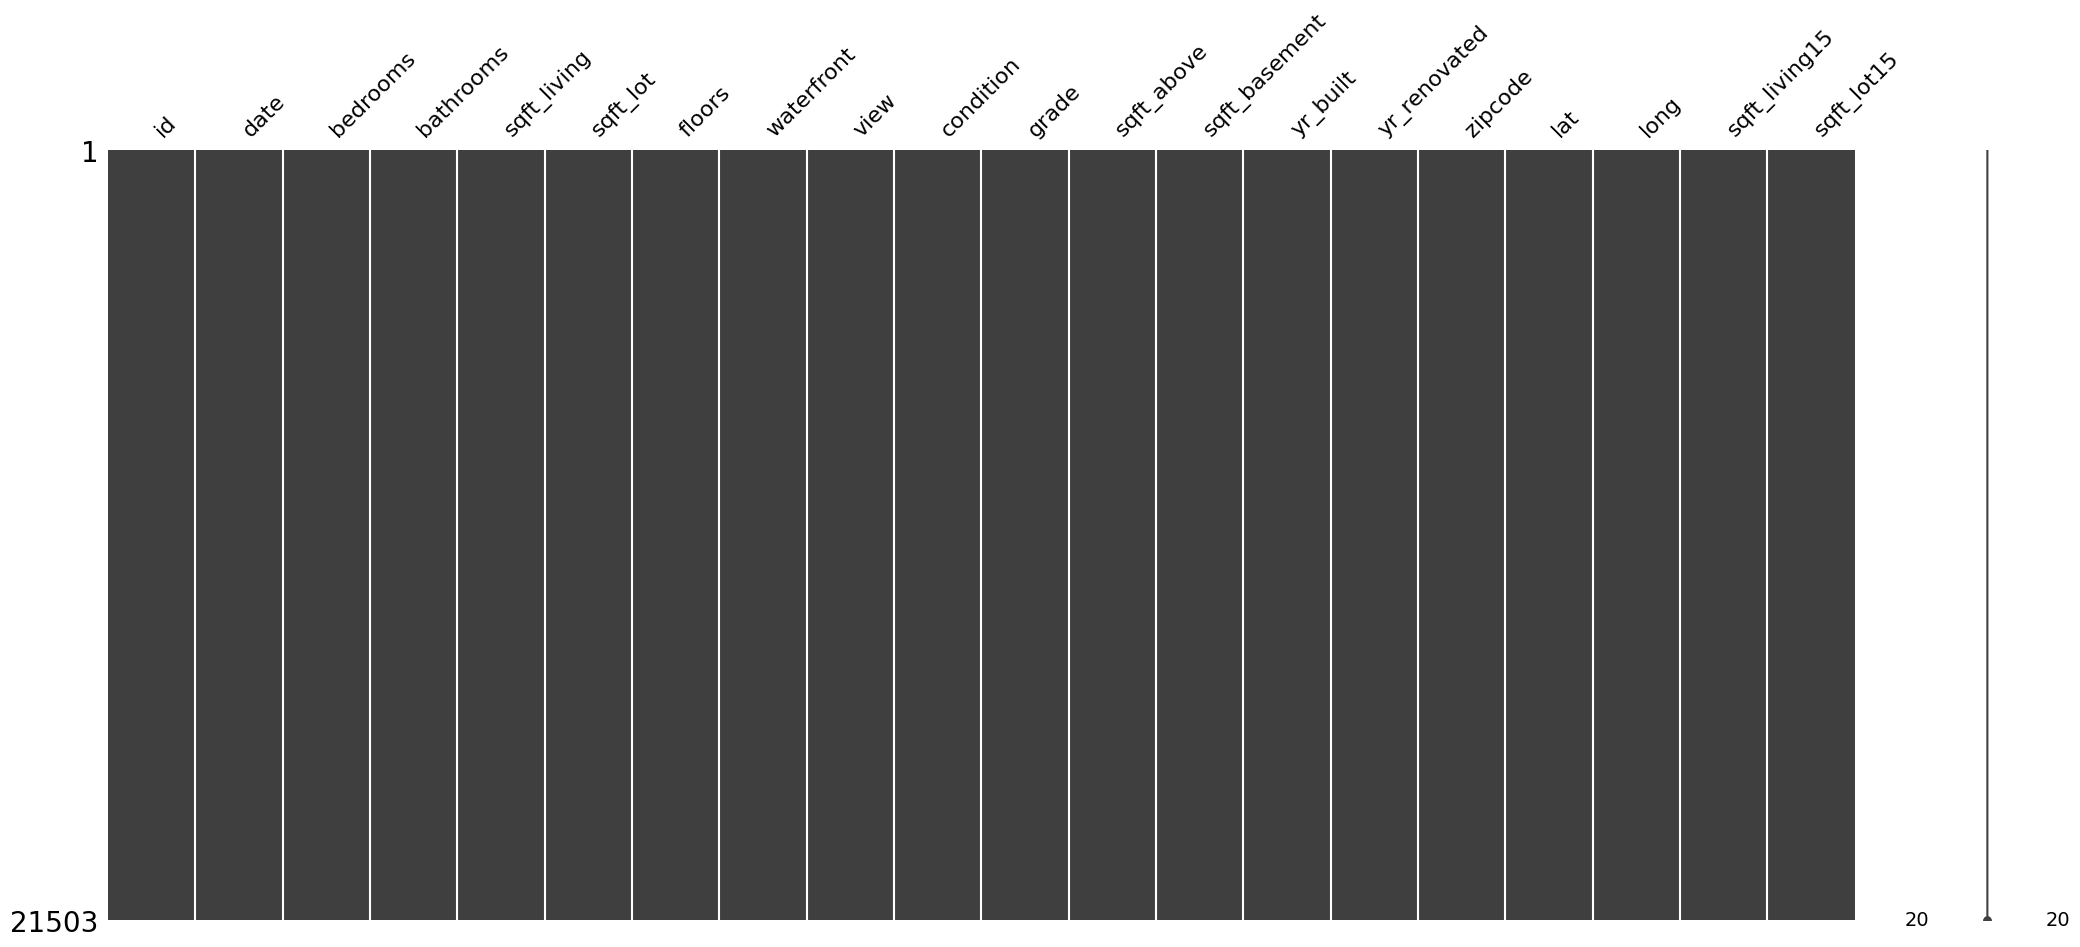

In [36]:
import missingno as msno 
msno.matrix(data)

### id, date 변수 정리하기


In [37]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


**date 컬럼 자르기**

In [39]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 각 변수들의 분포 확인 및 변환하기

그래프의 종류 [sns.kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html)을 사용.
kdeplot : 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 하는 시각화

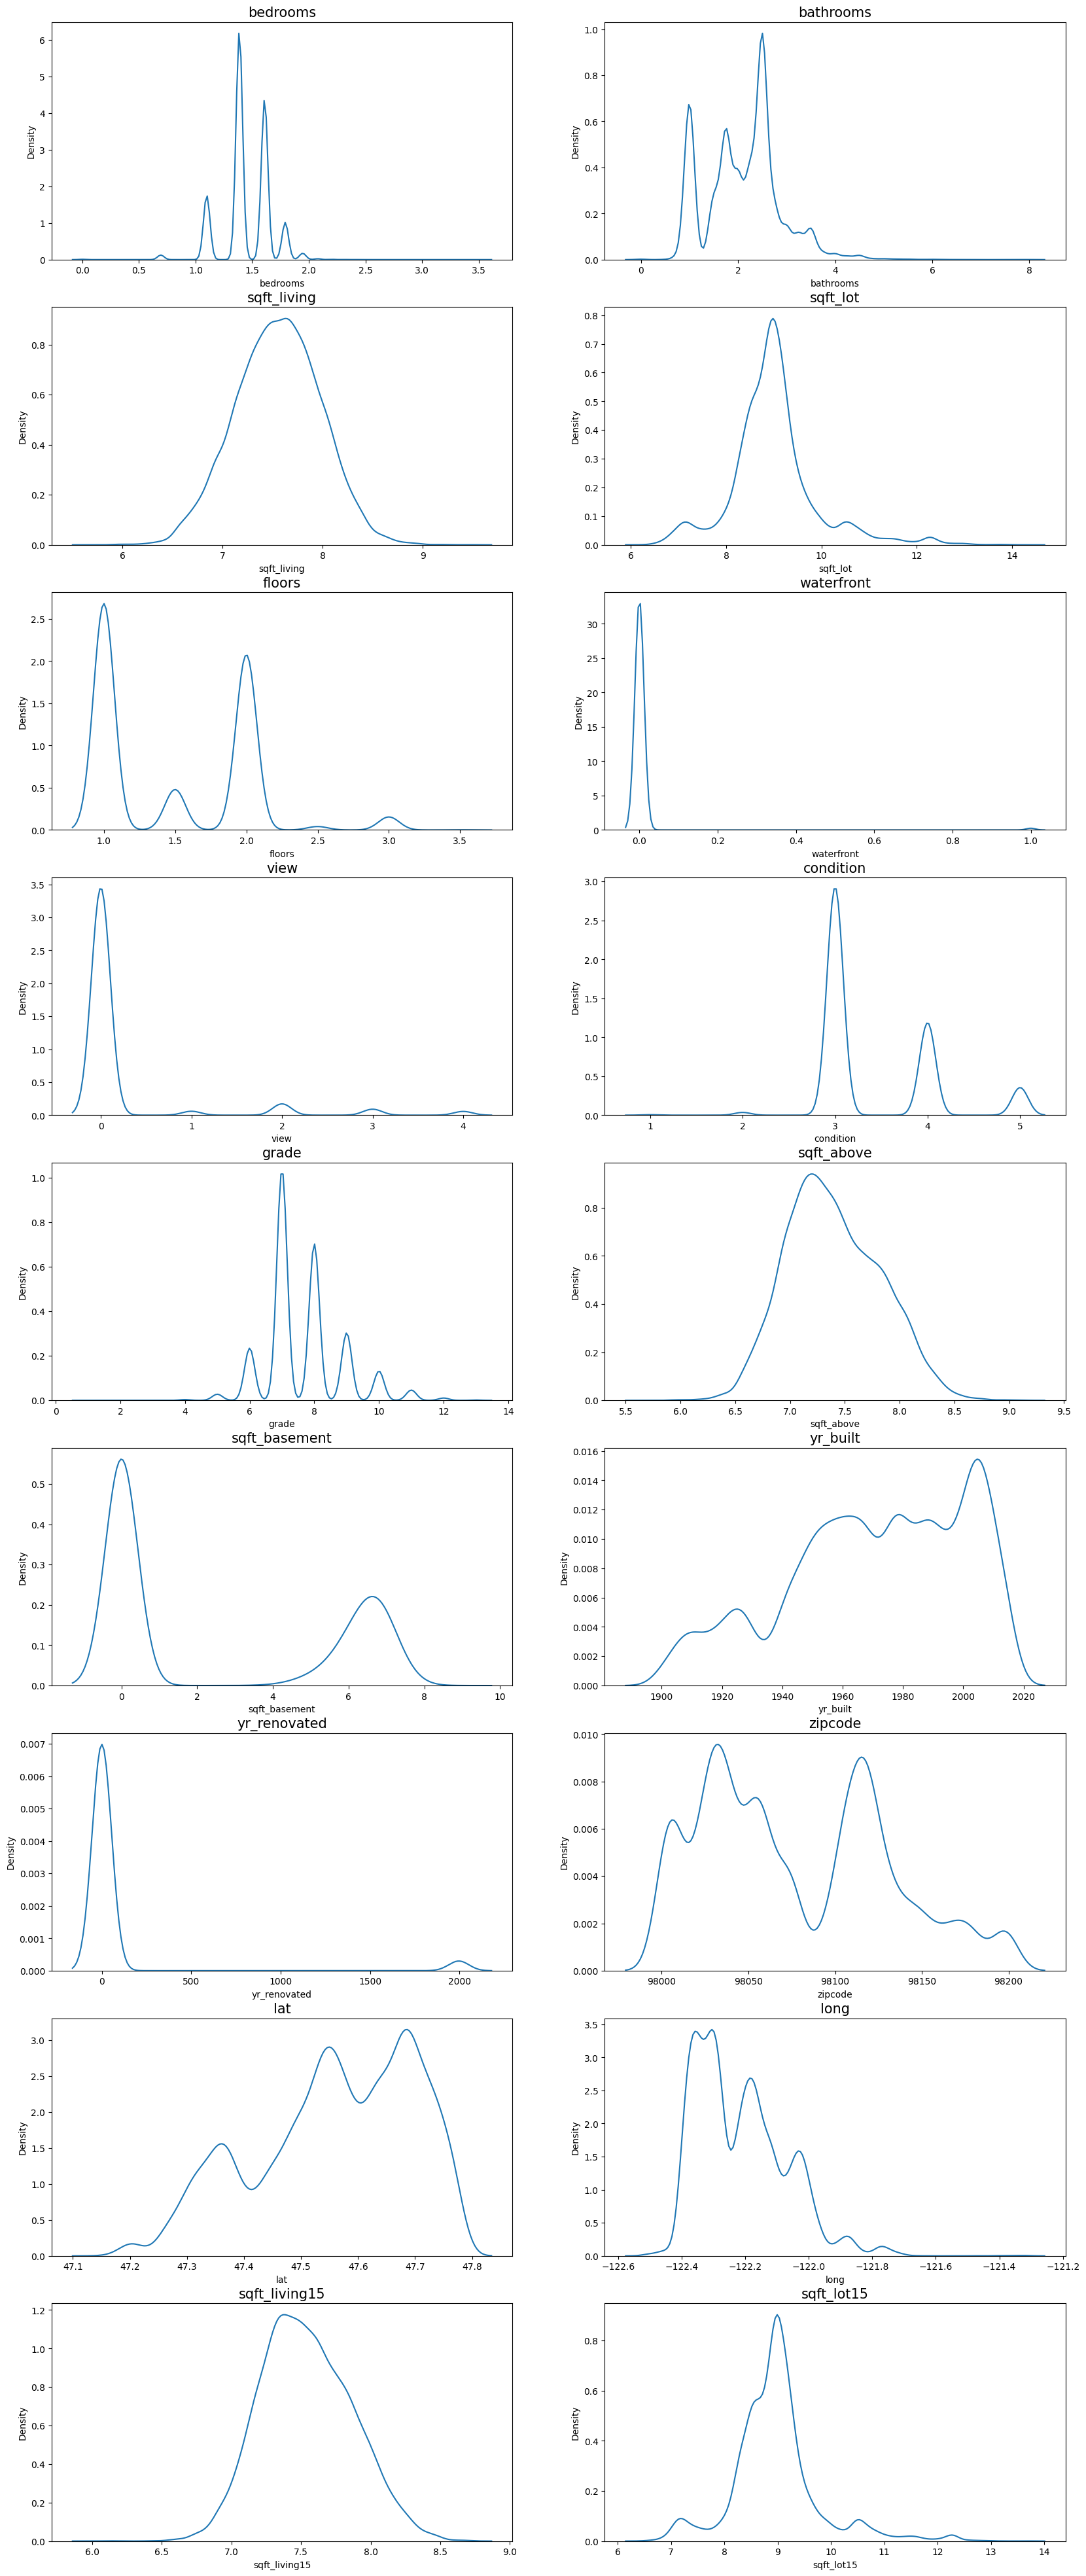

In [56]:
fig, ax = plt.subplots(9, 2, figsize=(20, 50)) 

# id 변수(count==0인 경우)는 제외하고 분포를 확인
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

이렇게 한 쪽으로 치우친 분포의 경우에는 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포에 가깝게 만들어 줄 수 있음

In [49]:
# 치우친 분포의 컬럼을 저장
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c])

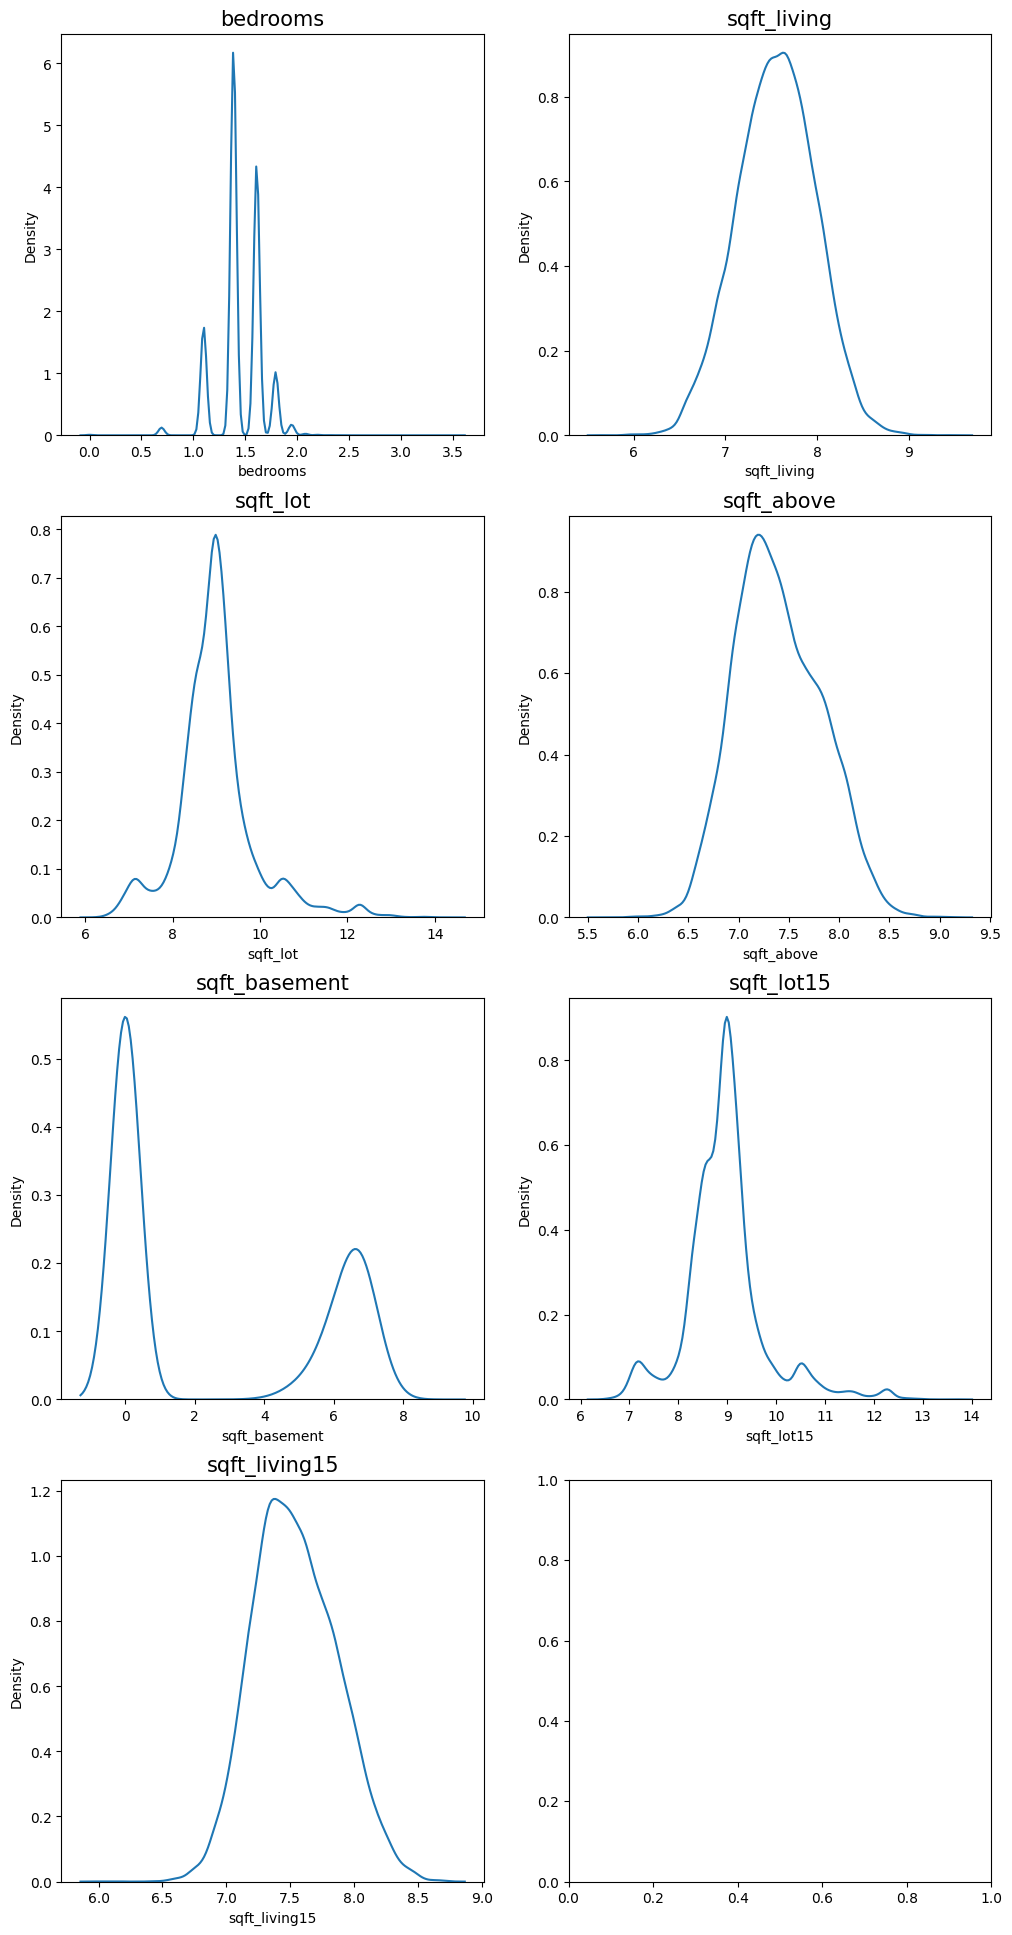

In [50]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

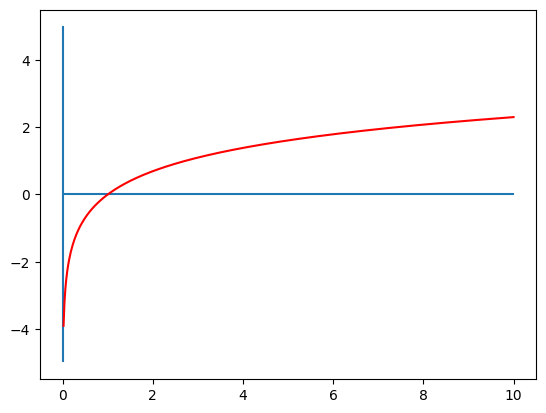

In [51]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

로그 함수 특징

- 0<x<1 범위에서는 기울기가 매우 가파름. 즉, x의 구간은 (0,1)로 매우 짧은 반면, y의 구간은 (−∞,0)으로 매우 큼.
- 따라서 0에 가깝게 모여있는 값들이 x로 입력되면, 그 함수값인 y 값들은 매우 큰 범위로 벌어지게 됨. 즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가짐
- 반면, x값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아짐. 이는 곧 큰 x값들에 대해서는 y값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 x를 비교적 작은 y값의 구간 내에 모이게 하는 특징을 가짐


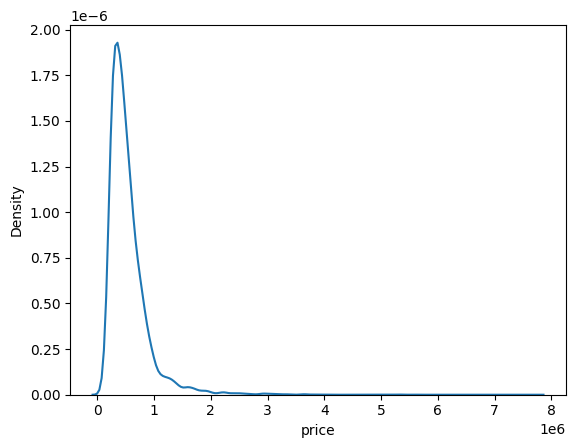

In [52]:
sns.kdeplot(y) # y는 미션 2에서 price를 저장하고 있음.
plt.show()

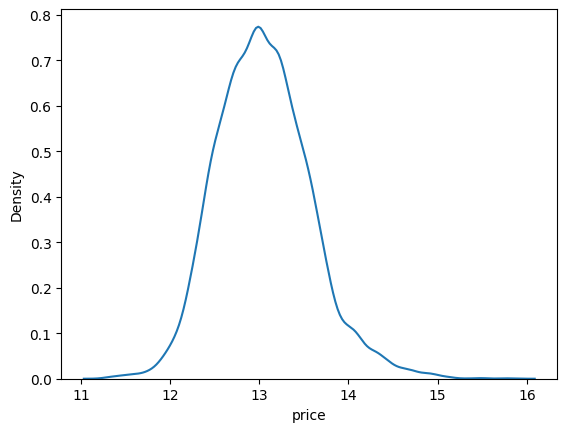

In [53]:
y_log_transformation = np.log1p(y) 

sns.kdeplot(y_log_transformation)
plt.show()

## 다시 학습데이터와 테스트 데이터 분리

위에서 저장해두었던 `train_len`을 인덱스로 활용 -> `:train_len`까지는 학습 데이터, 즉 `x`에 저장,`train_len:` 부터는 테스트 데이터, 즉 `sub` 변수에 저장

In [54]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)
